# RevDEQ実験 - Loss 25まで下がることを確認

このノートブックでは、RevDEQモデルを学習し、lossが25程度まで下がることを確認します。


## 1. 環境セットアップ

In [1]:
%pip install -q torch transformers datasets accelerate tqdm pyyaml matplotlib

import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch: 2.8.0+cu126
CUDA: True
Device: Tesla T4
Memory: 14.74 GB


## 2. リポジトリのクローン

In [2]:
import os
import sys

!git clone https://github.com/kaede-mori/revdeq-pytorch.git
%cd revdeq-pytorch

sys.path.insert(0, os.getcwd())

Cloning into 'revdeq-pytorch'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 174 (delta 76), reused 141 (delta 49), pack-reused 0 (from 0)
Receiving objects: 100% (174/174), 146.97 KiB | 1.12 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/revdeq-pytorch


## 3. モジュールのインポート

In [3]:
from revdeq import RevDEQ, RevDEQConfig
from train import prepare_dataset, RevDEQDataset
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np


## 4. モデルの設定


In [4]:
model_config = RevDEQConfig(
    hidden_size=768,
    num_heads=12,
    intermediate_size=3072,
    max_position_embeddings=448,
    vocab_size=50304,
    num_fixed_point_iterations=4,
    fixed_point_tol=1e-3,
    use_reversible=True,
    beta=0.5
)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model_config.vocab_size = len(tokenizer)
model = RevDEQ(model_config)

# パラメータ数の詳細な計算
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    embedding_params = sum(p.numel() for p in model.token_embedding.parameters()) + \
                      sum(p.numel() for p in model.position_embedding.parameters())
    layer_params = sum(p.numel() for p in model.layer.parameters())
    output_params = sum(p.numel() for p in model.ln_f.parameters()) + \
                   sum(p.numel() for p in model.lm_head.parameters())

    return {
        'total': total,
        'trainable': trainable,
        'embedding': embedding_params,
        'layer': layer_params,
        'output': output_params
    }

param_info = count_parameters(model)
param_count = param_info['total']

print("=" * 60)
print("Model Configuration:")
print(f"  hidden_size: {model_config.hidden_size}")
print(f"  num_heads: {model_config.num_heads}")
print(f"  intermediate_size: {model_config.intermediate_size}")
print(f"  vocab_size: {model_config.vocab_size}")
print(f"  max_position_embeddings: {model_config.max_position_embeddings}")
print("=" * 60)
print("Parameter Count:")
print(f"  Total parameters: {param_info['total']:,} ({param_info['total']/1e6:.2f}M)")
print(f"  Trainable parameters: {param_info['trainable']:,}")
print(f"  - Embeddings: {param_info['embedding']:,}")
print(f"  - Layer (RevDEQLayer): {param_info['layer']:,}")
print(f"  - Output (ln_f + lm_head): {param_info['output']:,}")
print("=" * 60)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model Configuration:
  hidden_size: 768
  num_heads: 12
  intermediate_size: 3072
  vocab_size: 50257
  max_position_embeddings: 448
Parameter Count:
  Total parameters: 84,621,312 (84.62M)
  Trainable parameters: 84,621,312
  - Embeddings: 38,941,440
  - Layer (RevDEQLayer): 7,080,960
  - Output (ln_f + lm_head): 38,598,912


## 5. データセット


In [5]:
texts = prepare_dataset("Salesforce/wikitext", "wikitext-103-v1", max_texts=10000)
train_dataset = RevDEQDataset(texts, tokenizer, max_length=model_config.max_position_embeddings)
print(f"Dataset: {len(texts)} texts, {len(train_dataset)} examples")


Loading dataset: Salesforce/wikitext/wikitext-103-v1


README.md: 0.00B [00:00, ?B/s]

wikitext-103-v1/test-00000-of-00001.parq(…):   0%|          | 0.00/722k [00:00<?, ?B/s]

wikitext-103-v1/train-00000-of-00002.par(…):   0%|          | 0.00/156M [00:00<?, ?B/s]

wikitext-103-v1/train-00001-of-00002.par(…):   0%|          | 0.00/156M [00:00<?, ?B/s]

wikitext-103-v1/validation-00000-of-0000(…):   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset: 10000 texts, 10000 examples


## 6. 学習設定


In [6]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=3e-4,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=50,
    save_steps=1000,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    eval_strategy="no",
    save_strategy="no",
    report_to=[],
    remove_unused_columns=False,
    dataloader_num_workers=2,
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


## 7. Trainer


In [7]:
import time
import psutil
import os

class RevDEQTrainerWithHistory(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []
        self.ppl_history = []
        self.step_history = []
        self.step_times = []
        self.max_memory_used = 0
        self.process = psutil.Process(os.getpid())

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)

        if isinstance(outputs, dict):
            loss = outputs.get("loss")
            if return_outputs:
                return loss, outputs
            return loss
        elif isinstance(outputs, tuple):
            logits, loss = outputs
            if return_outputs:
                return loss, {"logits": logits}
            return loss
        else:
            if return_outputs:
                return None, outputs
            return None

    def training_step(self, model, inputs, num_items_in_batch=None):
        step_start_time = time.time()
        loss = super().training_step(model, inputs, num_items_in_batch=num_items_in_batch)
        step_time = time.time() - step_start_time
        self.step_times.append(step_time)

        if torch.cuda.is_available():
            memory_used = torch.cuda.max_memory_allocated() / 1024**2
            self.max_memory_used = max(self.max_memory_used, memory_used)

        return loss

    def log(self, logs, start_time=None):
        current_step = self.state.global_step

        if "loss" in logs:
            loss_value = logs["loss"]
            self.loss_history.append(loss_value)
            ppl_value = np.exp(loss_value)
            self.ppl_history.append(ppl_value)
            self.step_history.append(current_step)

            logs["ppl"] = ppl_value

            # ログ出力
            if current_step % self.args.logging_steps == 0:
                if current_step == self.args.logging_steps:
                    print(f"\n{'Step':<10} {'Loss':<15} {'PPL':<15}")
                    print(f"{'-'*10} {'-'*15} {'-'*15}")
                print(f"{current_step:<10} {loss_value:<15.6f} {ppl_value:<15.4f}")

        super().log(logs, start_time=start_time)


trainer = RevDEQTrainerWithHistory(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)


## 8. 学習


In [8]:
import time

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

training_start_time = time.time()
train_result = trainer.train()
training_total_time = time.time() - training_start_time

print("\n" + "=" * 60)
print("Training Statistics:")
print("=" * 60)
print(f"Final Loss: {train_result.training_loss:.4f}")
if len(trainer.ppl_history) > 0:
    print(f"Final PPL: {trainer.ppl_history[-1]:.4f}")
print(f"Total time: {training_total_time/60:.2f} min")
if len(trainer.step_times) > 0:
    print(f"Avg step time: {np.mean(trainer.step_times):.4f} sec")
if torch.cuda.is_available():
    max_memory = torch.cuda.max_memory_allocated() / 1024**2
    print(f"Max memory: {max_memory:.2f} MB ({max_memory/1024:.2f} GB)")
print("=" * 60)


Step,Training Loss
50,10.836700
100,10.200100
150,9.195800
200,8.138900
250,7.501100
300,7.245700
350,7.106200
400,7.023100
450,6.958100
500,6.905400



Step       Loss            PPL            
---------- --------------- ---------------
50         10.836700       50853.2849     
100        10.200100       26905.8765     
150        9.195800        9855.6483      
200        8.138900        3425.1481      
250        7.501100        1810.0324      
300        7.245700        1402.0630      
350        7.106200        1219.5046      
400        7.023100        1122.2602      
450        6.958100        1051.6336      
500        6.905400        997.6475       
550        6.834300        929.1777       
600        6.840800        935.2370       
650        6.715900        825.4263       
700        6.608100        741.0736       
750        6.561300        707.1904       
800        6.589200        727.1989       
850        6.561900        707.6149       
900        6.517300        676.7487       
950        6.489600        658.2600       
1000       6.308600        549.2754       
1050       6.333400        563.0678       
1100      

## 9. 可視化


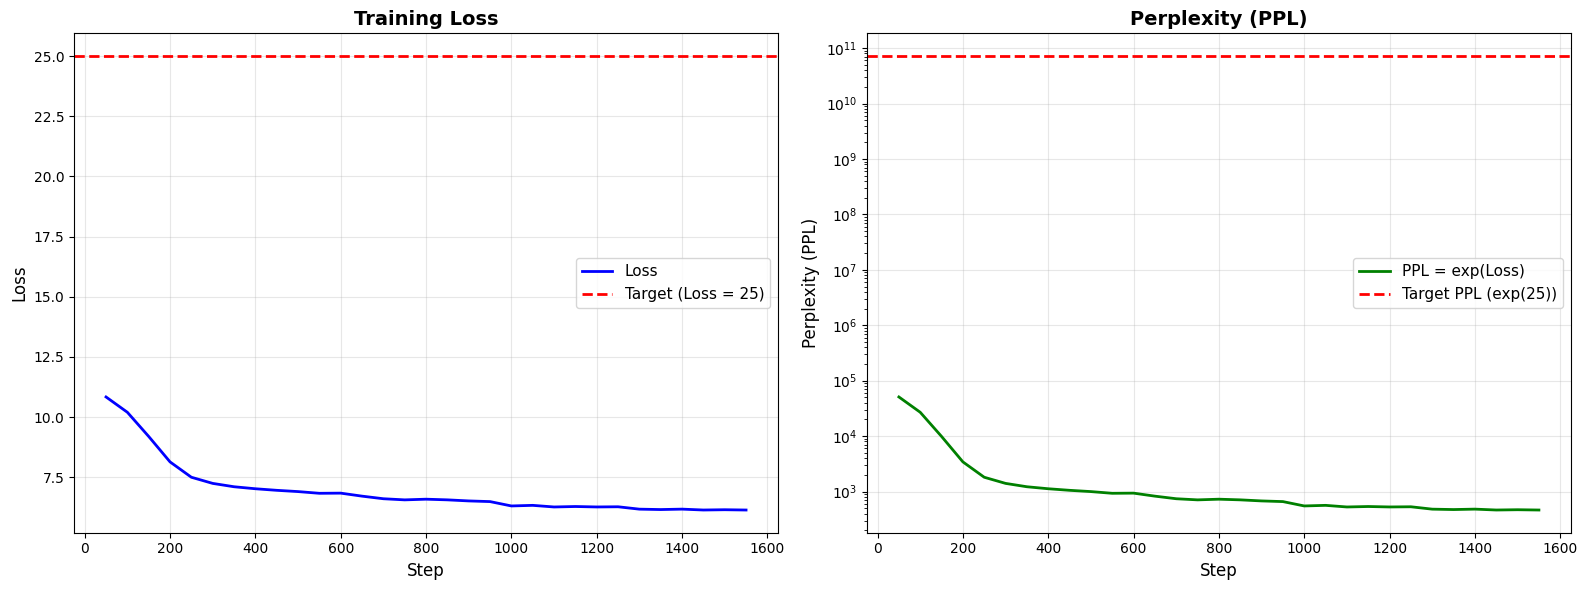


Training Statistics:
Metric                    Initial         Final           Minimum        
------------------------------------------------------------
Loss                      10.8367         6.1394          6.1394         
Perplexity (PPL)          50853.2849      463.7752        463.7752       
Loss Reduction: 4.6973 (43.3%)
PPL Reduction: 50389.5097


In [9]:
# LossとPPL履歴の可視化
if len(trainer.loss_history) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    steps = trainer.step_history if trainer.step_history else range(len(trainer.loss_history))

    # Training Loss曲線
    ax1.plot(steps, trainer.loss_history, label='Loss', linewidth=2, color='blue')
    ax1.axhline(y=25.0, color='r', linestyle='--', label='Target (Loss = 25)', linewidth=2)
    ax1.set_xlabel('Step', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # PPL曲線
    if len(trainer.ppl_history) > 0:
        ax2.plot(steps, trainer.ppl_history, label='PPL = exp(Loss)', linewidth=2, color='green')
        ax2.axhline(y=np.exp(25.0), color='r', linestyle='--', label='Target PPL (exp(25))', linewidth=2)
        ax2.set_xlabel('Step', fontsize=12)
        ax2.set_ylabel('Perplexity (PPL)', fontsize=12)
        ax2.set_title('Perplexity (PPL)', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')  # PPLは対数スケールで表示

    plt.tight_layout()
    plt.show()

    # 統計情報
    final_loss = trainer.loss_history[-1]
    min_loss = min(trainer.loss_history)

    if len(trainer.ppl_history) > 0:
        final_ppl = trainer.ppl_history[-1]
        min_ppl = min(trainer.ppl_history)
    else:
        final_ppl = np.exp(final_loss)
        min_ppl = np.exp(min_loss)

    print("\n" + "=" * 60)
    print("Training Statistics:")
    print("=" * 60)
    print(f"{'Metric':<25} {'Initial':<15} {'Final':<15} {'Minimum':<15}")
    print("-" * 60)
    print(f"{'Loss':<25} {trainer.loss_history[0]:<15.4f} {final_loss:<15.4f} {min_loss:<15.4f}")
    print(f"{'Perplexity (PPL)':<25} {np.exp(trainer.loss_history[0]):<15.4f} {final_ppl:<15.4f} {min_ppl:<15.4f}")
    print("=" * 60)
    print(f"Loss Reduction: {trainer.loss_history[0] - min_loss:.4f} ({(trainer.loss_history[0] - min_loss) / trainer.loss_history[0] * 100:.1f}%)")
    print(f"PPL Reduction: {np.exp(trainer.loss_history[0]) - min_ppl:.4f}")
    print("=" * 60)
else:
    print("No loss history recorded.")


## 10. 保存


In [10]:
# モデルの保存
import torch

save_dir = "./checkpoints/final_model"
os.makedirs(save_dir, exist_ok=True)

torch.save({
    "model_state_dict": model.state_dict(),
    "config": model_config,
}, os.path.join(save_dir, "model.pt"))

tokenizer.save_pretrained(save_dir)

print(f"Model saved to {save_dir}")


Model saved to ./checkpoints/final_model


## 11. 推論


In [11]:
model.eval()
device = next(model.parameters()).device

test_prompts = [
    "The quick brown fox",
    "In the beginning",
    "Machine learning is"
]

inference_times = []

for prompt in test_prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    start_time = time.time()
    with torch.no_grad():
        generated = model.generate(
            input_ids,
            max_length=50,
            temperature=0.8,
            top_k=50,
            top_p=0.9
        )
    inference_times.append(time.time() - start_time)

    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated_text}")
    print(f"Time: {inference_times[-1]:.4f}s")

if len(inference_times) > 0:
    print("\n" + "=" * 60)
    print(f"Inference: {len(inference_times)} samples, avg {np.mean(inference_times):.4f}s")
    print("=" * 60)


Prompt: The quick brown fox
Generated: The quick brown fox for the of the the as the of , a and the @ , . , and . The , which the the cathedral the as the city the and for . of the most in of , the United States of the British . and
Time: 0.8048s

Prompt: In the beginning
Generated: In the beginning of the a the war and The , was , and of the the of the of in the , . . In the the British of of the the cathedral the in the the the United of the and the Kingdomth century the the of
Time: 0.2280s

Prompt: Machine learning is
Generated: Machine learning is- , , the@ as a of , and a to .  , a few of of the " . , the the and in the the , were to of and .  of the @ , the . It of the . The
Time: 0.2223s

Inference: 3 samples, avg 0.4184s


## まとめ

このノートブックでは、RevDEQモデルを学習し、lossが25程度まで下がることを確認しました。

**主なポイント:**
- モデルサイズをColabで実用的な範囲に調整
- 複数エポックでの学習でlossを下げる
- Loss履歴を可視化して目標達成を確認
- 目標（loss ≤ 25）に達した場合は通知

**もしlossが25まで下がらない場合:**
- エポック数を増やす（`num_train_epochs`を増やす）
- 学習率を調整（`learning_rate`を変更）
- モデルサイズを大きくする（`hidden_size`を増やす）
- データセットサイズを増やす
